In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [183]:
x_train = pd.read_csv('x_train_full.csv')
x_val = pd.read_csv('x_val_full.csv')
x_test = pd.read_csv('x_test_full.csv')
y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

In [184]:
label_dict = {1:0, 0:1, -1:2 }
y_train['target'] = y_train['result'].map(label_dict)
y_val['target'] =  y_val['result'].map(label_dict)
y_test['target'] =  y_test['result'].map(label_dict)

In [156]:
## Rebalance proportion of home wins/draws/home losses
indices = y_train[y_train['result'] == 1].sample(frac = 0.35).index.values
mask_y= ~ y_train.index.isin(indices)
mask_x= ~ x_train.index.isin(indices)
y_train = y_train[mask_y]
x_train = x_train[mask_x]
assert len(x_train) == len(y_train)
assert (x_train.index == y_train.index).sum()
assert (x_train.match_api_id == y_train.match_api_id).sum()

In [185]:
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train.iloc[:,1:])

x_train = pd.DataFrame(min_max_scaler.transform(x_train.iloc[:,1:]), index = x_train['match_api_id'], columns = x_train.iloc[:,1:].columns)
x_val = pd.DataFrame(min_max_scaler.transform(x_val.iloc[:,1:]), index = x_val['match_api_id'], columns = x_val.iloc[:,1:].columns)
x_test = pd.DataFrame(min_max_scaler.transform(x_test.iloc[:,1:]), index = x_test['match_api_id'], columns = x_test.iloc[:,1:].columns)

In [186]:
y_train['result'].value_counts(normalize=True)

 1    0.458586
-1    0.289090
 0    0.252324
Name: result, dtype: float64

In [226]:
# Build Network
input_size = len(x_train.columns)
hidden_sizes = [256,512,256,64,32,16]
output_size = 3

# Build a feed-forward network
LinearNN = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                         nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax()
                        )



In [270]:
# Hyperparameters

batch_size =  len(x_train)
epochs = 100
learning_rate = 0.00001
loss = 0
losses = []
counter = 0

dataset = TensorDataset( Tensor(x_train.values), torch.Tensor(y_train['target'].values) )
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

optimizer = torch.optim.Adam(LinearNN.parameters(), lr=learning_rate, betas=(0.9,0.999))

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20 , gamma = 0.1)
mse = torch.nn.MSELoss()
cross = nn.CrossEntropyLoss()

Loss after iteration 0: 0.997261643409729
Elapsed time: 108.5738456249237 s
0.9969560503959656


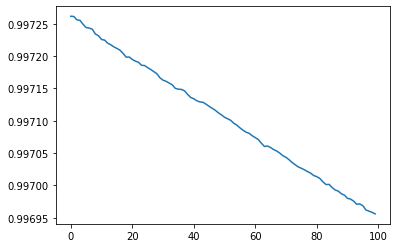

In [271]:
#Train Model

t = time.time()
for epoch in range(epochs):
    for x, y in iter(train_loader):
        LinearNN.train()
        LinearNN.zero_grad()
        
        y_pred = LinearNN(x)
        loss = cross(y_pred, y.long())
        
        if counter % 500 ==0:
            print('Loss after iteration {}: {}'.format(counter, loss.item()))
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        counter+=1 
    counter+=1
    #scheduler.step()
time.time()-t        
        
        
print('Elapsed time: {} s'.format(time.time()-t))    
print(loss.item())  
plt.plot(range(len(losses)), losses)
plt.show()

In [272]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_val.values))
    train_pred = LinearNN(Tensor(x_train.values))
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
y_train_pred = pd.Series(train_pred.max(1).indices).map({0:1,1:0,2:-1})

print(sklearn.metrics.accuracy_score(y_train_pred, y_train['result']))
print(sklearn.metrics.accuracy_score(y_val_pred, y_val['result']))

0.5311581598992383
0.5219378427787934


In [273]:
y_val_pred.value_counts()

 1    795
-1    299
dtype: int64

In [274]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_test.values))
    
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
sklearn.metrics.accuracy_score(y_val_pred, y_test['result'])

0.5443732845379688

In [275]:
y_val_pred.value_counts()

 1    797
-1    296
dtype: int64

In [200]:
val_pred[y_val['result'] == 0]

IndexError: The shape of the mask [1094] at index 0does not match the shape of the indexed tensor [1093, 3] at index 0

In [253]:
y_pred[:,1].max()

tensor(0.2545, grad_fn=<MaxBackward1>)